In [2]:
setwd("C:\\Users\\Ermias\\Documents\\data visualization\\R_project")

### Load libraries

In [9]:
library(data.table)
library(stats)

 ### 🧬=== GSE58135 Dataset Preprocessing and Distance Matrix Calculation ===

In [30]:
# === Load Data ===
# Count matrix (genes x samples)
count_matrix <- fread("GSE58135.countmatrix.txt", header = TRUE)
rownames(count_matrix) <- count_matrix[[1]]
count_matrix <- as.matrix(count_matrix[ , -1, with = FALSE])

# Load annotation (row names might contain commas)
annotation <- read.csv("SraRunTable_GSE58135.pam50.txt", header = TRUE, row.names = 1)
clean_ids <- sub(",.*", "", rownames(annotation))  # Remove everything after comma
rownames(annotation) <- clean_ids

# Keep only common samples between count matrix and annotation
common_samples <- intersect(colnames(count_matrix), rownames(annotation))
count_matrix <- count_matrix[, common_samples]
group_labels <- annotation[common_samples, "source_name"]

# === Filter genes with zero variance  ===
count_matrix <- count_matrix[apply(count_matrix, 1, var) > 0, ]

# === Normalize ===
norm_matrix <- log2(count_matrix + 1)

# === Calculate Distance Matrix ===
distMatrix <- dist(t(norm_matrix), method = "euclidean")
distMatrix <- as.matrix(distMatrix)

print(round(distMatrix[1:6,1:6], 2))  # Print first 6x6 portion for sanity check


           SRR1313160 SRR1313187 SRR1313130 SRR1313120 SRR1313129 SRR1313207
SRR1313160       0.00     712.01     979.96     855.00     797.08     323.05
SRR1313187     712.01       0.00     426.91     402.63     326.83     591.51
SRR1313130     979.96     426.91       0.00     352.50     332.46     868.52
SRR1313120     855.00     402.63     352.50       0.00     307.40     751.94
SRR1313129     797.08     326.83     332.46     307.40       0.00     689.76
SRR1313207     323.05     591.51     868.52     751.94     689.76       0.00


### === Hobotnica function ===

In [43]:
Hobotnica <- function(distMatrix, annotation, verbose=FALSE){
  annotation <- as.vector(annotation)

  rank.m <- as.matrix(distMatrix)
  rank.m[lower.tri(rank.m)] <- rank(rank.m[lower.tri(rank.m)])
  rank.m[upper.tri(rank.m)] <- rank(rank.m[upper.tri(rank.m)])

     if (verbose) {
    cat("Sample of Rank Matrix (5x5 block):\n")
    print(rank.m[1:min(5,nrow(rank.m)), 1:min(5,ncol(rank.m))])
  }
  inclass_sum <- 0
  classes <- unique(annotation)
  Ns <- numeric(length(classes))
  
  for (i in seq_along(classes)){
    class_samples <- which(annotation == classes[i])
    Ns[i] <- length(class_samples)
    inclass_sum <- inclass_sum + sum(rank.m[class_samples, class_samples])
  }
  
  Ns_sum <- sum(Ns)
  biggest_rank <- Ns_sum * (Ns_sum - 1) / 2
  inclass_unique <- sum(Ns * (Ns - 1)) / 2
  maximal_value <- inclass_unique * (2 * biggest_rank - inclass_unique + 1)
  minimal_value <- inclass_unique * (1 + inclass_unique)
  norm_factor <- maximal_value - minimal_value
  
  if (verbose) {
    cat("maximal_value =", maximal_value, "\n")
    cat("minimal_value =", minimal_value, "\n")
    cat("norm_factor =", norm_factor, "\n")
    cat("inclass_sum =", inclass_sum, "\n")
  }
  
  H <- max(0, 1 - (inclass_sum - minimal_value) / norm_factor)
  return(H)
}

H_score <- Hobotnica(distMatrix, group_labels, verbose=TRUE)

Sample of Rank Matrix (5x5 block):
           SRR1313160 SRR1313187 SRR1313130 SRR1313120 SRR1313129
SRR1313160          0       8988       9680       9524       9340
SRR1313187       8988          0       4386       3438       1017
SRR1313130       9680       4386          0       1644       1129
SRR1313120       9524       3438       1644          0        738
SRR1313129       9340       1017       1129        738          0
maximal_value = 52841138 
minimal_value = 10643906 
norm_factor = 42197232 
inclass_sum = 21247012 


### === Permutation function for p-value ===

In [32]:
Hobot_distr <- function(N, distMatrix, annotation){
  hobots <- numeric(N)
  for (i in 1:N){
    shuffled <- sample(annotation)
    hobots[i] <- Hobotnica(distMatrix, shuffled, verbose=FALSE)
  }
  return(hobots)
}

### === Calculate p-value ===

In [33]:
Hobot_pval <- function(test_hobot, hobot_distr){
  p_val <- mean(hobot_distr <= test_hobot)
  return(p_val)
}

### === Run Hobotnica ===

In [34]:
set.seed(42)
hobot_distribution <- Hobot_distr(10000, distMatrix, group_labels)
p_value <- (sum(hobot_distribution >= H_score) + 1) / (length(hobot_distribution) + 1)
#p_value <- Hobot_pval(H_score, hobot_distribution)
cat("H-score:", H_score, "\n")
cat("P-value:", p_value, "\n")

H-score: 0.7487251 
P-value: 9.999e-05 


In [35]:
cat("Number of samples:", length(group_labels), "\n")
cat("Number of groups:", length(unique(group_labels)), "\n")
table(group_labels)


Number of samples: 140 
Number of groups: 3 


group_labels
            ER+ Breast Cancer Primary Tumor 
                                         42 
                                     Normal 
                                         56 
Triple Negative Breast Cancer Primary Tumor 
                                         42 

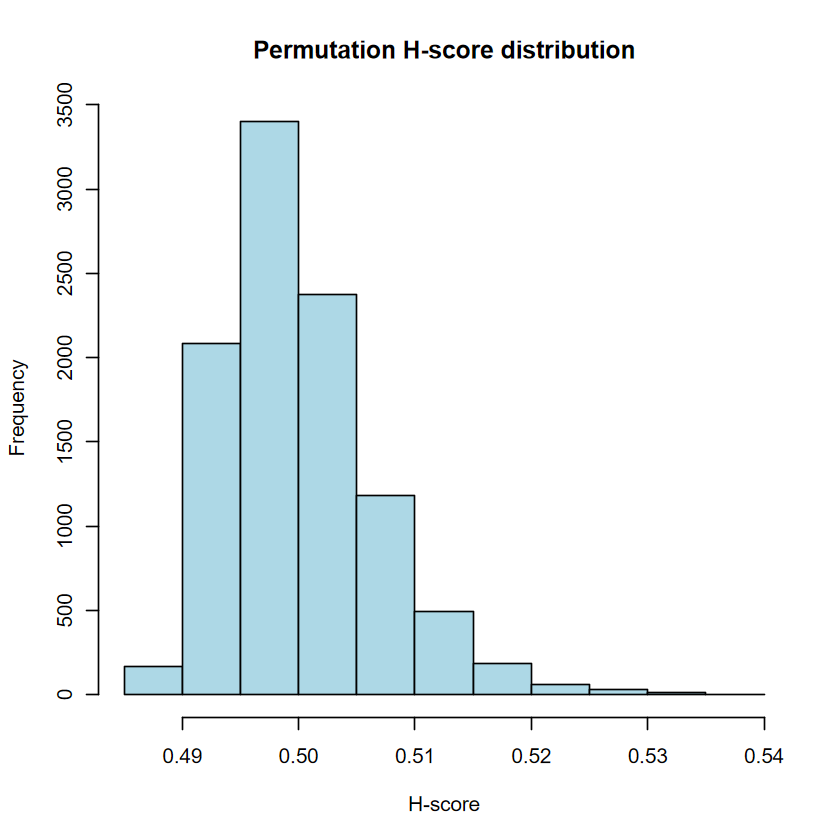

In [45]:
hist(hobot_distribution, main="Permutation H-score distribution", xlab="H-score", col="lightblue")
abline(v=H_score, col="blue", lwd=2)
